In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from glicko2 import Player

In [66]:
csv_path='data/0824.csv'

In [67]:

# モデルのレーティングを保持する辞書
models = {}

# レーティング変更履歴を保存するリスト
rating_history = []

def get_or_create_player(model_name):
    if model_name not in models:
        models[model_name] = Player(rating=1500, rd=350, vol=0.06)
    return models[model_name]

def update_ratings(model1, model2, result, index):
    player1 = get_or_create_player(model1)
    player2 = get_or_create_player(model2)
    
    # 更新前のレーティングとRDを保存
    rating1, rd1 = player1.rating, player1.rd
    rating2, rd2 = player2.rating, player2.rd
    
    # result: 1 = model1の勝利, 0.5 = 引き分け, 0 = model2の勝利
    player1.update_player([rating2], [rd2], [result])
    player2.update_player([rating1], [rd1], [1 - result])
    
    # レーティング変更履歴を保存
    rating_history.append({
        'index': index,
        'model1': model1,
        'model2': model2,
        'rating1_before': rating1,
        'rating1_after': player1.rating,
        'rating2_before': rating2,
        'rating2_after': player2.rating,
        'result': result
    })


In [105]:
#モデルの対戦回数と勝率
total_battle_count = {}
win_count = {}
total_battles=0
# CSVファイルを読み込む
with open(csv_path, 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    next(reader)  # ヘッダーをスキップ
    
    for index, row in enumerate(reader, start=1):
        try:
            evaluation = int(row[3])
        except:
            continue  # 評価が空白のものはスキップ
        model1 = row[5]
        model2 = row[6]
        total_battles+=1
        
        if evaluation == 1:
            update_ratings(model1, model2, 1, index)
        elif evaluation == 2:
            update_ratings(model1, model2, 0, index)
        elif evaluation == 3:  # 両方良い場合（引き分け）
            update_ratings(model1, model2, 0.5, index)
        elif evaluation == 0:  # 両方良い場合（引き分け）
            update_ratings(model1, model2, 0.5, index)


        # evaluation が 0 の場合は更新しない（両方悪い場合）

        # モデルの対戦回数と勝率を更新
        if model1 not in total_battle_count:
            total_battle_count[model1] = 0
            win_count[model1] = 0
        if model2 not in total_battle_count:
            total_battle_count[model2] = 0
            win_count[model2] = 0
        total_battle_count[model1] += 1
        total_battle_count[model2] += 1
        if evaluation == 1:
            win_count[model1] += 1
        elif evaluation == 2:
            win_count[model2] += 1

total_battle_count,win_count

({'team-hatakeyama-phase2/Tanuki-8x8B-dpo-v1.0': 329,
  'weblab-GENIAC/Tanuki-8B-dpo-v1.0': 330,
  'cyberagent/calm3-22b-chat': 337,
  'tokyotech-llm/Llama-3-Swallow-70B-Instruct-v0.1': 295,
  'karakuri-ai/karakuri-lm-8x7b-chat-v0.1': 290,
  'gpt-3.5-turbo': 249,
  'gpt-4o-mini-2024-07-18': 260,
  'plamo-beta': 244,
  'gpt-4o-2024-05-13': 247,
  'elyza/Llama-3-ELYZA-JP-8B': 223,
  'gemini-1.5-pro': 170,
  'gemini-1.5-flash': 242,
  'claude-3-5-sonnet-20240620': 198},
 {'team-hatakeyama-phase2/Tanuki-8x8B-dpo-v1.0': 135,
  'weblab-GENIAC/Tanuki-8B-dpo-v1.0': 94,
  'cyberagent/calm3-22b-chat': 129,
  'tokyotech-llm/Llama-3-Swallow-70B-Instruct-v0.1': 44,
  'karakuri-ai/karakuri-lm-8x7b-chat-v0.1': 65,
  'gpt-3.5-turbo': 42,
  'gpt-4o-mini-2024-07-18': 112,
  'plamo-beta': 69,
  'gpt-4o-2024-05-13': 144,
  'elyza/Llama-3-ELYZA-JP-8B': 40,
  'gemini-1.5-pro': 85,
  'gemini-1.5-flash': 105,
  'claude-3-5-sonnet-20240620': 112})

In [106]:
sum(total_battle_count.values())/2,total_battles

(1707.0, 1707)

In [107]:
#boundには1σの値を入れる
sigma_val=1

# 結果をレーティング順にソートして表示
print("Model Ratings (sorted by rating):")
sorted_models = sorted(models.items(), key=lambda x: x[1].rating, reverse=True)

sorted_data=[]
for model, player in sorted_models:
    rating = player.rating
    rd = player.rd
    lower_bound = rating - sigma_val * rd
    upper_bound = rating + sigma_val * rd
    print(f"{model}: Rating = {rating:.2f}, RD = {rd:.2f} (95% CI: {lower_bound:.2f} - {upper_bound:.2f})")
    
    #モデル名の表記を微修正
    if model.find("/")!=-1:
        model_=model.split("/")[1]
    else:
        model_=model
    if model.find("plamo")!= -1:
        model_="PLAMO-100B"
    model_=model_.replace("gpt","GPT")
    model_=model_.replace("3-5","3.5")
    #先頭文字は大文字
    model_=model_[0].upper()+model_[1:]
    
    #勝率
    win_rate=win_count[model]/total_battle_count[model]
    d={"name":model_,"name_original":model,
       "win_rate":win_rate,
       "total_battle_count":total_battle_count[model],
       "rating":rating,"rd":rd,
       "lower_bound":lower_bound,"upper_bound":upper_bound,

       }
      
       
    sorted_data.append(d)

"""
# レーティング変更履歴をCSVファイルに保存
with open('data/rating_history.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=[
        'index', 'model1', 'model2', 'rating1_before', 'rating1_after',
        'rating2_before', 'rating2_after', 'result'
    ])
    writer.writeheader()
    writer.writerows(rating_history)

print("Rating history has been saved to 'rating_history.csv'")
"""

Model Ratings (sorted by rating):
claude-3-5-sonnet-20240620: Rating = 1689.85, RD = 62.78 (95% CI: 1627.07 - 1752.63)
gpt-4o-2024-05-13: Rating = 1645.07, RD = 63.78 (95% CI: 1581.29 - 1708.86)
team-hatakeyama-phase2/Tanuki-8x8B-dpo-v1.0: Rating = 1577.91, RD = 61.63 (95% CI: 1516.28 - 1639.55)
gemini-1.5-flash: Rating = 1572.66, RD = 61.47 (95% CI: 1511.19 - 1634.12)
gemini-1.5-pro: Rating = 1562.91, RD = 61.12 (95% CI: 1501.79 - 1624.03)
gpt-4o-mini-2024-07-18: Rating = 1559.30, RD = 61.28 (95% CI: 1498.02 - 1620.58)
cyberagent/calm3-22b-chat: Rating = 1533.32, RD = 61.34 (95% CI: 1471.99 - 1594.66)
weblab-GENIAC/Tanuki-8B-dpo-v1.0: Rating = 1490.07, RD = 61.50 (95% CI: 1428.57 - 1551.57)
plamo-beta: Rating = 1466.95, RD = 61.37 (95% CI: 1405.58 - 1528.33)
gpt-3.5-turbo: Rating = 1411.34, RD = 63.16 (95% CI: 1348.18 - 1474.50)
elyza/Llama-3-ELYZA-JP-8B: Rating = 1407.50, RD = 62.26 (95% CI: 1345.24 - 1469.76)
karakuri-ai/karakuri-lm-8x7b-chat-v0.1: Rating = 1404.64, RD = 62.49 (95% 

'\n# レーティング変更履歴をCSVファイルに保存\nwith open(\'data/rating_history.csv\', \'w\', newline=\'\', encoding=\'utf-8\') as file:\n    writer = csv.DictWriter(file, fieldnames=[\n        \'index\', \'model1\', \'model2\', \'rating1_before\', \'rating1_after\',\n        \'rating2_before\', \'rating2_after\', \'result\'\n    ])\n    writer.writeheader()\n    writer.writerows(rating_history)\n\nprint("Rating history has been saved to \'rating_history.csv\'")\n'

Text(0, 0.5, 'Model name')

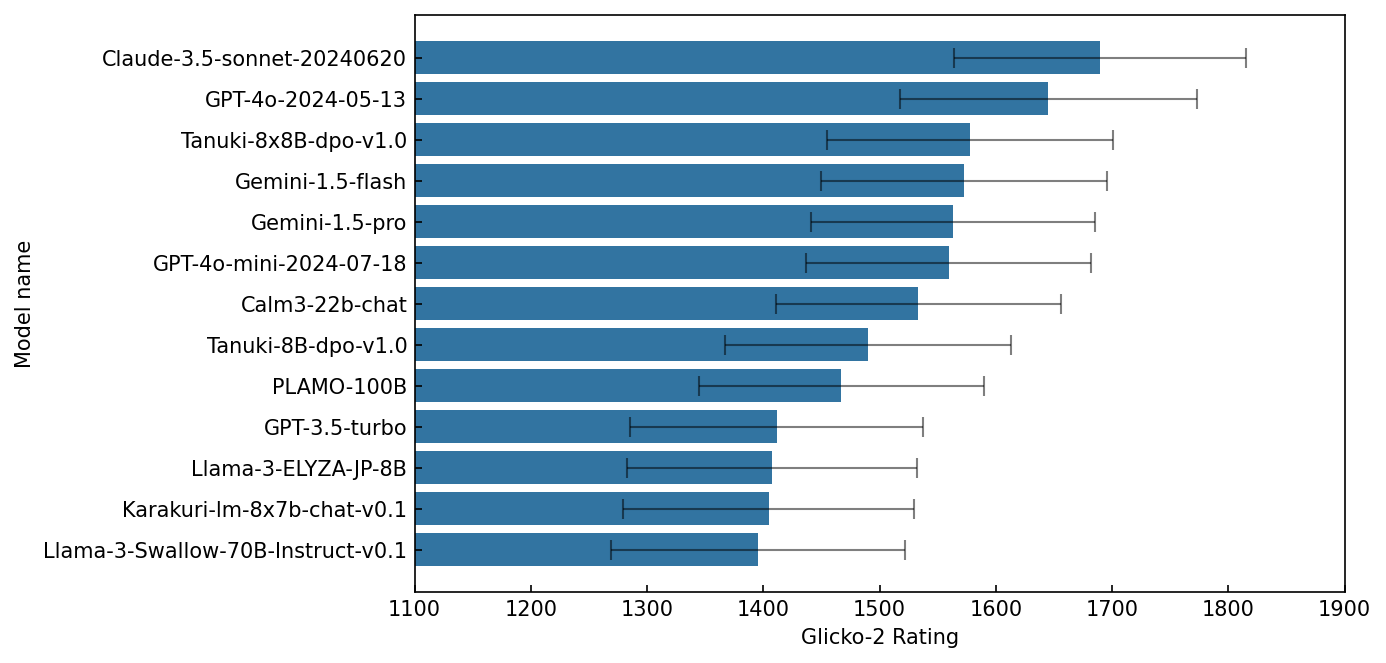

In [108]:
#2sigmaでのグラフ
df=pd.DataFrame(sorted_data)
plt.figure(figsize=(8,5),dpi=150)
sns.barplot(x="rating",y="name",data=df)
#エラーバーを表示. プロットは打たない
plt.errorbar(df["rating"],df["name"],xerr=df["rd"]*2,fmt='None',color='black',capsize=5,elinewidth=1,alpha=0.5)
plt.xlim(1100,1900)
plt.xlabel("Glicko-2 Rating")
plt.ylabel("Model name")

Text(0, 0.5, 'Model name')

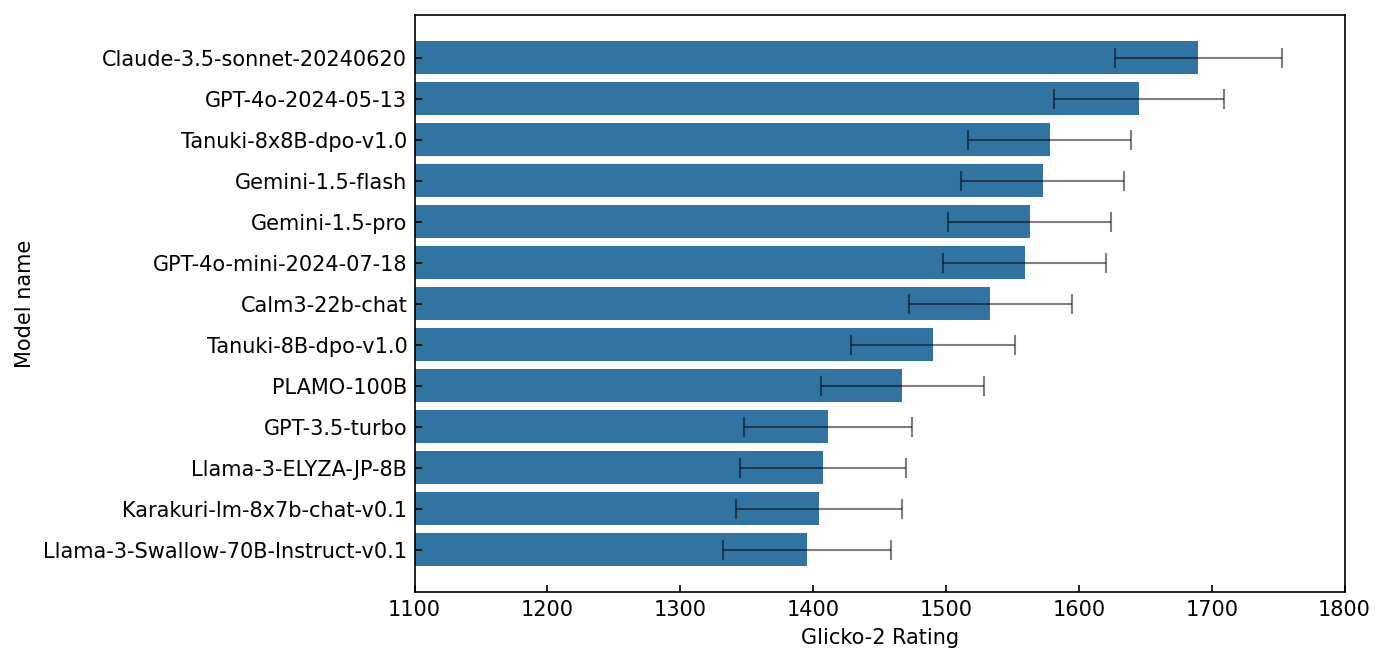

In [109]:
#1sigmaでのグラフ
df=pd.DataFrame(sorted_data)
plt.figure(figsize=(8,5),dpi=150)
sns.barplot(x="rating",y="name",data=df)
#エラーバーを表示. プロットは打たない
plt.errorbar(df["rating"],df["name"],xerr=df["rd"],fmt='None',color='black',capsize=5,elinewidth=1,alpha=0.5)
plt.xlim(1100,1800)
plt.xlabel("Glicko-2 Rating")
plt.ylabel("Model name")

In [116]:
#信頼区間での順位を予測
import copy

df=pd.DataFrame(sorted_data)
df["lowerst_rank"]=0
df["highest_rank"]=0
model_list=df["name"].tolist()


for model in model_list:
    df_lowest=copy.deepcopy(df)
    #当該モデルにとって最も悲観的なレーティングを設定
    df_lowest["rating"]=df_lowest["upper_bound"]
    df_lowest.loc[df_lowest["name"] == model, "rating"] = df_lowest.loc[df_lowest["name"] == model, "lower_bound"]

    #レーティング順にソート
    df_lowest=df_lowest.sort_values("rating",ascending=False).reset_index(drop=True)
    
    #当該モデルの順位を取得
    rank=df_lowest[df_lowest["name"]==model].index[0]+1
    df.loc[df["name"]==model,"lowerst_rank"]=rank

    #当該モデルにとって最も楽観的なレーティングを設定
    df_highest=copy.deepcopy(df)
    df_highest["rating"]=df_highest["lower_bound"]
    df_highest.loc[df_highest["name"] == model, "rating"] = df_highest.loc[df_highest["name"] == model, "upper_bound"]

    #レーティング順にソート
    df_highest=df_highest.sort_values("rating",ascending=False).reset_index(drop=True)

    #当該モデルの順位を取得
    rank=df_highest[df_highest["name"]==model].index[0]+1
    df.loc[df["name"]==model,"highest_rank"]=rank


df["rank_range"]=df["highest_rank"].astype(str)+"-"+df["lowerst_rank"].astype(str)
df["rating"]=df["rating"].astype(int)
df["lower_bound"]=df["lower_bound"].astype(int)
df["upper_bound"]=df["upper_bound"].astype(int)
df["rd"]=df["rd"].astype(int)
df["win_rate"]=df["win_rate"].map(lambda x:round(x,2))
df=df.drop(["lowerst_rank","highest_rank","name_original","lower_bound","upper_bound"],axis=1)


#leaderboard3の結果も反映
ld3_score_dict={
'Claude-3.5-sonnet-20240620':0.82,
 'GPT-4o-2024-05-13':0.78,
 'Tanuki-8x8B-dpo-v1.0':0.57,
 'Gemini-1.5-pro':0.73,
 'Gemini-1.5-flash':0.70,
 'GPT-4o-mini-2024-07-18':0.72,
 'Calm3-22b-chat':0.65,
 'Tanuki-8B-dpo-v1.0':0.52,
 'PLAMO-100B':-1,
 'Llama-3-ELYZA-JP-8B':0.62,
 'Karakuri-lm-8x7b-chat-v0.1':0.6,
 'GPT-3.5-turbo':0.58,
 'Llama-3-Swallow-70B-Instruct-v0.1':0.65,
}
df["LD3-ave"]=df["name"].map(ld3_score_dict)

#ld3のmt benchも反映
ld3_mt_score_dict={
'Claude-3.5-sonnet-20240620':8.7,
 'GPT-4o-2024-05-13':8.6,
 'Tanuki-8x8B-dpo-v1.0':7.0,
 'Gemini-1.5-pro':7.9,
 'Gemini-1.5-flash':7.6,
 'GPT-4o-mini-2024-07-18':8.3,
 'Calm3-22b-chat':6.9,
 'Tanuki-8B-dpo-v1.0':6.6,
 'PLAMO-100B':-1,
 'Llama-3-ELYZA-JP-8B':6.1,
 'Karakuri-lm-8x7b-chat-v0.1':5.8,
 'GPT-3.5-turbo':6.8,
 'Llama-3-Swallow-70B-Instruct-v0.1':6.2,
}
df["JMT-Bench"]=df["name"].map(ld3_mt_score_dict)

df=df.sort_values("win_rate",ascending=False).reset_index(drop=True)
df.to_csv("data/leaderboard.csv",index=False)
df

,name,win_rate,total_battle_count,rating,rd,rank_range,LD3-ave,JMT-Bench
0,GPT-4o-2024-05-13,0.58,247,1645,63,1-7,0.78,8.6
1,Claude-3.5-sonnet-20240620,0.57,198,1689,62,1-4,0.82,8.7
2,Gemini-1.5-pro,0.50,170,1562,61,2-9,0.73,7.9
3,Gemini-1.5-flash,0.43,242,1572,61,1-9,0.70,7.6
4,GPT-4o-mini-2024-07-18,0.43,260,1559,61,2-9,0.72,8.3
5,Tanuki-8x8B-dpo-v1.0,0.41,329,1577,61,1-9,0.57,7.0
6,Calm3-22b-chat,0.38,337,1533,61,2-10,0.65,6.9
7,Tanuki-8B-dpo-v1.0,0.28,330,1490,61,3-13,0.52,6.6
8,PLAMO-100B,0.28,244,1466,61,3-13,-1.00,-1.0
9,Karakuri-lm-8x7b-chat-v0.1,0.22,290,1404,62,8-13,0.60,5.8


Text(0, 0.5, 'Win rate')

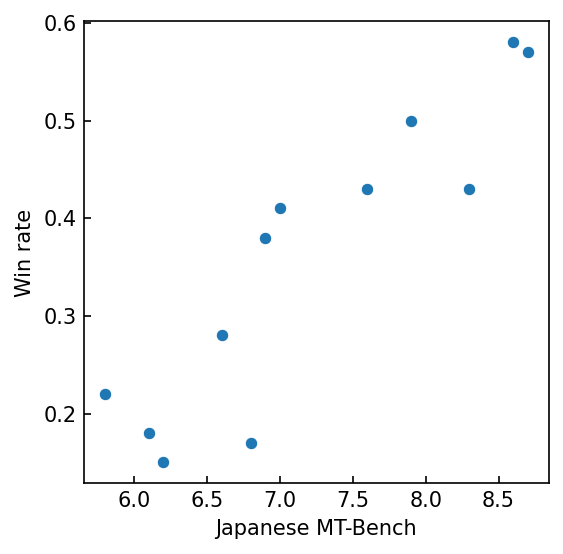

In [117]:
#メモリを内向き
plt.figure(figsize=(4,4),dpi=150)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

sns.scatterplot(x="JMT-Bench",y="win_rate",data=df[df["JMT-Bench"]!=-1])
plt.xlabel("Japanese MT-Bench")
plt.ylabel("Win rate")
#内向きメモリ


Text(0, 0.5, 'Rating')

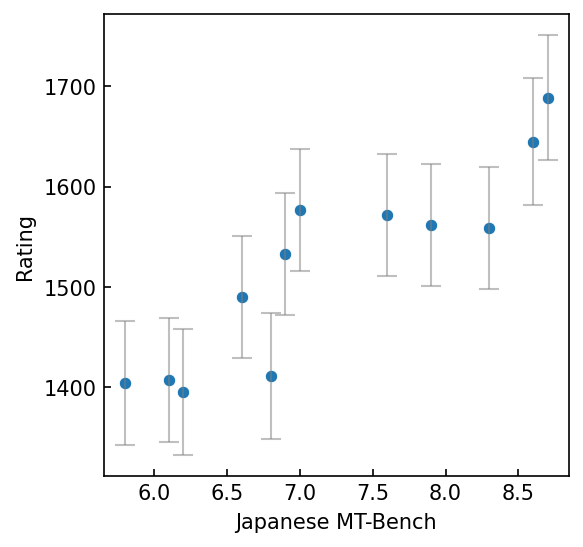

In [118]:

#メモリを内向き
plt.figure(figsize=(4,4),dpi=150)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

sns.scatterplot(x="JMT-Bench",y="rating",data=df[df["JMT-Bench"]!=-1])
#yはエラーバーも表示, rdの2倍
sel_df=df[df["JMT-Bench"]!=-1]
plt.errorbar(sel_df["JMT-Bench"],sel_df["rating"],yerr=sel_df["rd"],
             fmt='None',color='gray',capsize=5,elinewidth=1,alpha=0.5)
plt.xlabel("Japanese MT-Bench")
plt.ylabel("Rating")
#内向きメモリ


Text(0, 0.5, 'Win rate')

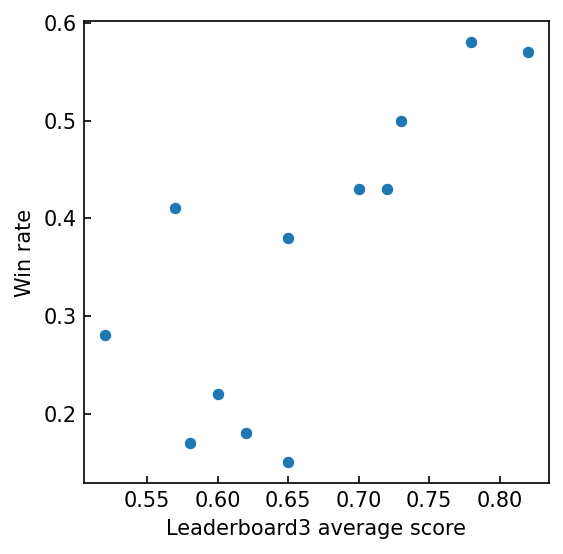

In [120]:

#メモリを内向き
plt.figure(figsize=(4,4),dpi=150)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

sns.scatterplot(x="LD3-ave",y="win_rate",data=df[df["JMT-Bench"]!=-1])
plt.xlabel("Leaderboard3 average score")
plt.ylabel("Win rate")
#内向きメモリ
